# Exercise 6: PCA for airfoils

In this exercise, we use Principal Component Analysis (PCA) to identify coherent patterns in flow data around an airfoil. In the fluid dynamics community, PCA is commonly known as Proper Orthogonal Decomposition (POD) [2].

**Data**
The dataset comes from a simulation of the NACA 0012 airfoil [1].
It contains the magnitude of the velocity field at each point in a 2D plane slice of a 3D simulation. The white region in the accompanying animation corresponds to the airfoil, and the color intensity indicates flow speed—faster flow appears brighter. Downstream of the foil, turbulent structures form and evolve over time.
![](velocity_animation.gif)
Originally, the data consist of about 22,000 spatial points per time step, distributed over an irregular mesh. For simplicity, we provide a resampled version on a regular 2D grid, stored in the file `velocities.npz`.
It contains 2D arrays where the width is $n_x = 500$ and the height is $n_y=207$.
We consider the flattened vectors without the $n_f$ pixels that represent the airfoil, so that
$$
\mathbf x_t \in \mathbb R^N 
$$
for grid size is $N=n_x \cdot n_y - n_f$.

**PCA**
We aim to extract dominant spatial modes that describe the temporal evolution of the flow field. PCA finds orthogonal directions in data space that capture maximal variance, allowing us to build a low-dimensional model with $k$ small that approximates $\mathbf x_t$ well:
$$
\mathbf{x}_t \approx \bar{\mathbf{x}} + \sum_{i=1}^{k} a_{i,t} \mathbf{u}_i,
$$
where  
- $ \bar{\mathbf{x}} $ is the mean field,  
- $ \mathbf{u}_i $ are the principal components (spatial modes),  
- $ a_{i,t} $ are their time-dependent amplitudes, and  
- $ k $ is the number of retained modes.
The covariance matrix is  
$$
C = \frac{1}{T} X_c^\top X_c,
$$
where $ X_c $ is the centered data matrix with columns $\mathbf{x}_t - \bar{\mathbf{x}}$.  
Eigenvalue decomposition
$$
C \mathbf{u}_i = \lambda_i \mathbf{u}_i
$$
yields the modes $\mathbf{u}_i$ and their explained variances $\lambda_i$.

**Goal**
In this exercise we apply PCA to the velocity data. We begin by loading and visualizing the dataset, centering it, and computing its principal components. We then examine the leading modes and plot the variance explained by each component. Finally, we reconstruct the flow field using a limited number of modes and compare the results to the original data, pondering on how one can use it (or not) for prediction. 

**Bonus** If you are interested in modelling turbulent flows with machine learning, check this [nice paper](https://arxiv.org/pdf/1811.11328).


### Exercise 1

**1.a)** Load the data from the file we provide for you. The `vel_grids` is a `(#sample, #width, #height)` array that contains the velocity for a given time step, at every point. The `foil_grid` is a binary mask that can be used to remove data that lies where the foil (wing, white area in the gif) lies, it is True if the pixel is lying within the foil wing.

How many pixels does the foil contain?

In [11]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt


data_file = np.load("velocities_small.npz") # you may use "velocities_small.npz" for faster data loading
vel_grids = data_file["mag"]        
vel_grids = np.flip(vel_grids, axis=1)
foil_grid = np.flip(data_file["mask_grid"],axis=0)   
print(vel_grids.shape) # (nt, NX, NY)
print(foil_grid.shape) # (NX, NY)
print("Data loaded.")

nt = vel_grids.shape[0]
NX = vel_grids.shape[1]
NY = vel_grids.shape[2]
NF = NX * NY - nt

print(f"\nSummary: \ntime steps nt={nt},\nheight NY={NY},\nwidth NX={NX},\nfoil pixels NF={NF}")


(200, 207, 500)
(207, 500)
Data loaded.

Summary: 
time steps nt=200,
height NY=500,
width NX=207,
foil pixels NF=103300


**1.b)** Plot the first time step $t=0$ of the simulation of the airfoil, and don't forget to apply the airfoil mask, by showing foil pixels as `np.nan`. The final image should be labeled and show the color bar for the velocity.

 *Tip:* Don't overwrite the `vel_grids` vector, use copy instead!

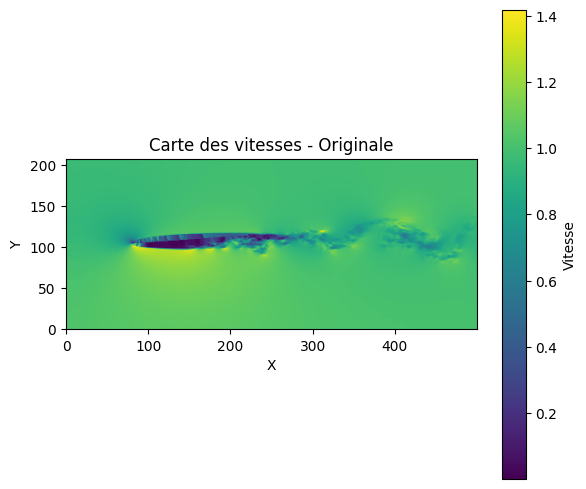

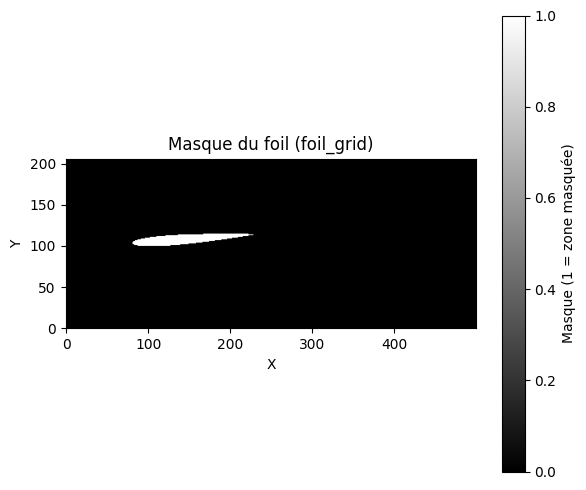

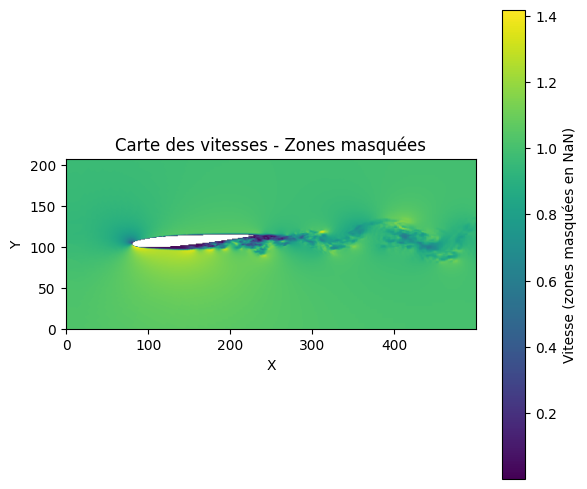

In [18]:
# Masquage propre avec copie explicite
vel_grids_copy = vel_grids.copy()
vel_grids_copy[0] = np.where(foil_grid == 1, np.nan, vel_grids[0])

# --- Figure 1 : Données originales ---
plt.figure(figsize=(6, 5))
plt.imshow(vel_grids[0], origin='lower', cmap='viridis')
plt.colorbar(label="Vitesse")
plt.title("Carte des vitesses - Originale")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

# --- Figure 2 : Masque (foil_grid) ---
plt.figure(figsize=(6, 5))
plt.imshow(foil_grid, origin='lower', cmap='gray')
plt.colorbar(label="Masque (1 = zone masquée)")
plt.title("Masque du foil (foil_grid)")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

# --- Figure 3 : Données masquées ---
plt.figure(figsize=(6, 5))
plt.imshow(vel_grids_copy[0], origin='lower', cmap='viridis')
plt.colorbar(label="Vitesse (zones masquées en NaN)")
plt.title("Carte des vitesses - Zones masquées")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

### Exercise 2

**2.a)** Use the `PCA` module from sklearn to find the principal components of the time data, rather than doing the eigendecomposition yourself. Don't forget to:
- Flatten the grid for every time step from 2d $\to$ 1d, as described in the introduction.
- Remove the airfoild data from the 1d vector, so that it only contains $N$ pixels per time step. 
- Subtract the mean of the data.
You should end up with a fitted `PCA` module that you can examine in the next steps.

*Hint:* Running the full PCA takes roughly a minute for the $1600$ time steps on a fast computer. In case you want to debug, try using fewer timesteps.

In [28]:
vel_grids_tab = []

for i in range(nt):
    # Sélectionne uniquement les valeurs où foil_grid != 1
    valid_values = vel_grids[i][foil_grid != 1]
    
    # Centre les données autour de leur moyenne
    centered_values = valid_values - np.mean(valid_values)
    
    # Stocke les données traitées dans une liste
    vel_grids_tab.append(centered_values)

print("✅ Data masked, flattened, and mean-centered.")
print(len(vel_grids_tab), "time steps of length", len(vel_grids_tab[0]))

✅ Data masked, flattened, and mean-centered.
200 time steps of length 102212


**2.b)** Visualize the first 10 principal components that you discovered. This requires extracting the vector from the `PCA` module (check the documentation online), and reformatting it to a 2d version. Again, don't forget to apply the mask to the visualization, so that values where the airfoil is are NaN and you see it as white pixels.

Bonus: How would you interpret these components in the context of a fluid?

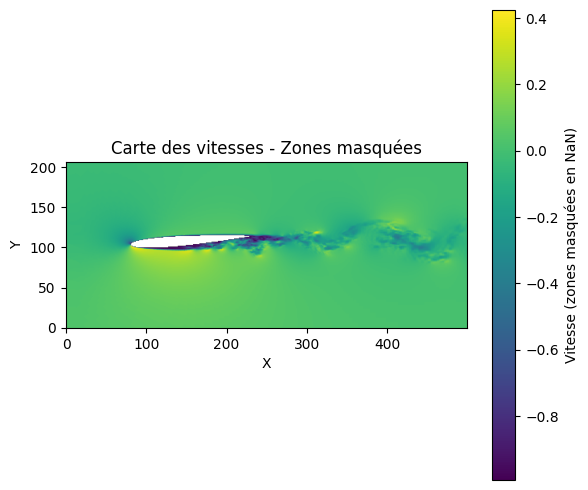

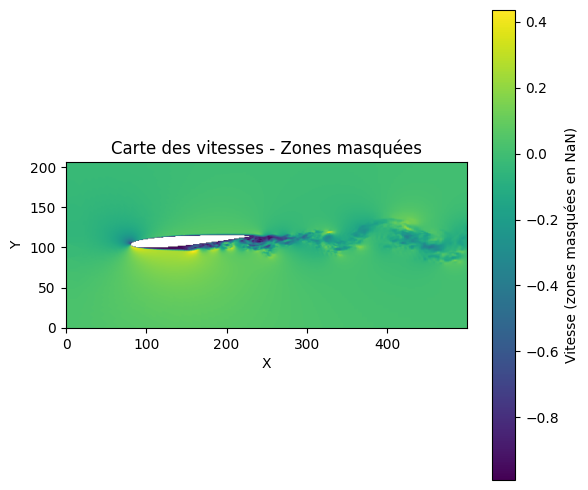

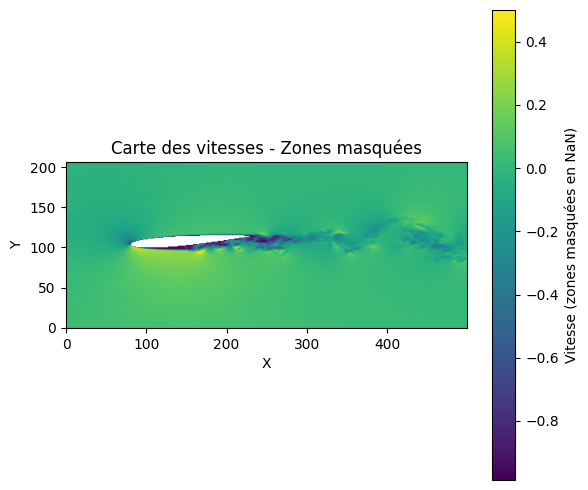

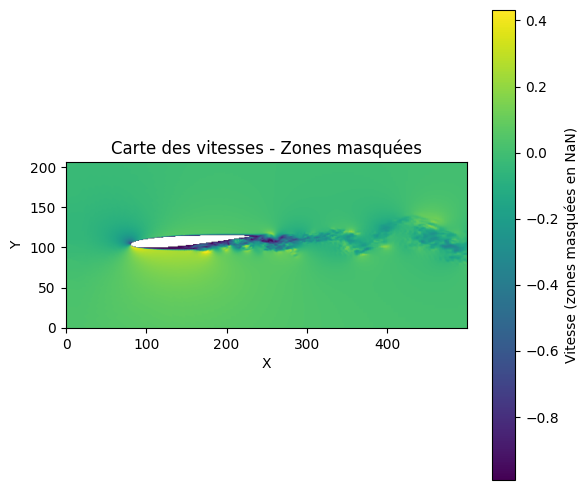

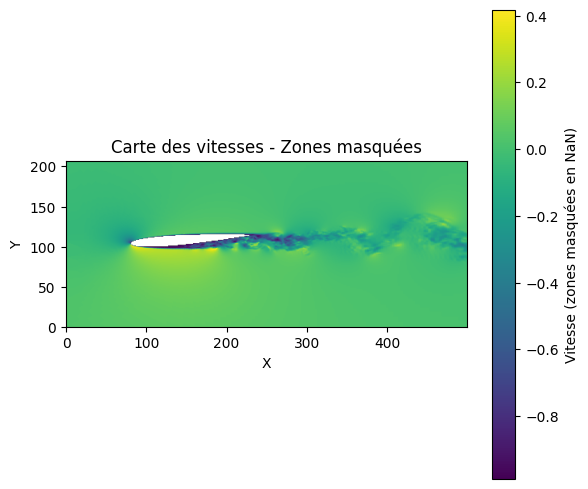

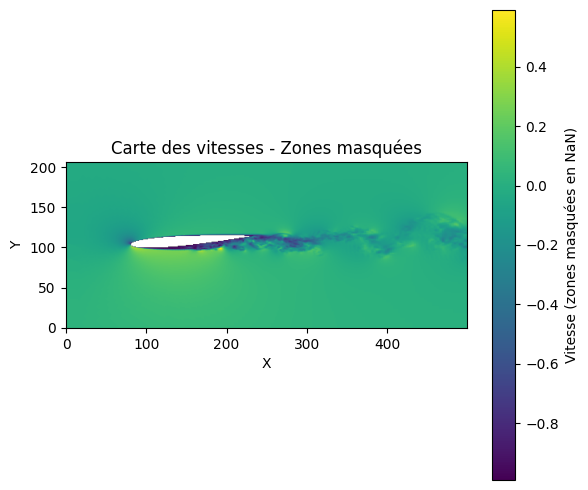

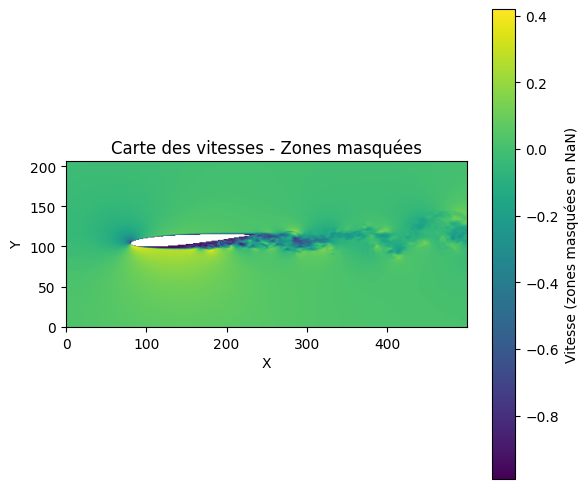

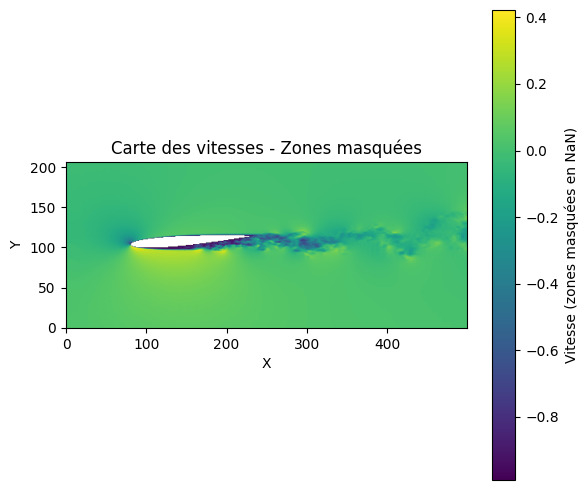

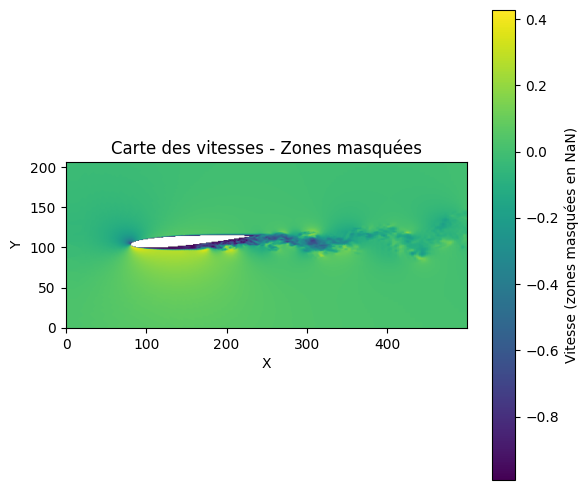

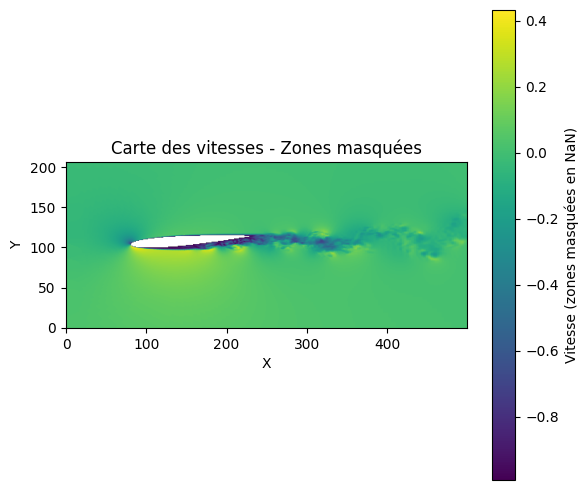

In [29]:
def visualize_2d(x):
    # convenience function to visualize a 1d vector x in 2d, applying the mask for the foil
    # x is assumed to be of shape (NF,) where NF is the number of non-masked pixels
    # returns a 2d array of shape (NY, NX) with NaNs where the mask is True
    grid_2d = np.full((NX, NY), np.nan)
    grid_2d[foil_grid == 0] = x
    return grid_2d

for i in range(10):
    plt.figure(figsize=(6, 5))
    plt.imshow(visualize_2d(vel_grids_tab[i]), origin='lower', cmap='viridis')
    plt.colorbar(label="Vitesse (zones masquées en NaN)")
    plt.title("Carte des vitesses - Zones masquées")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    plt.show()

**2.c)** Plot the cummulative explained variance ratio and show how many components are needed to explain 90% of the variance.

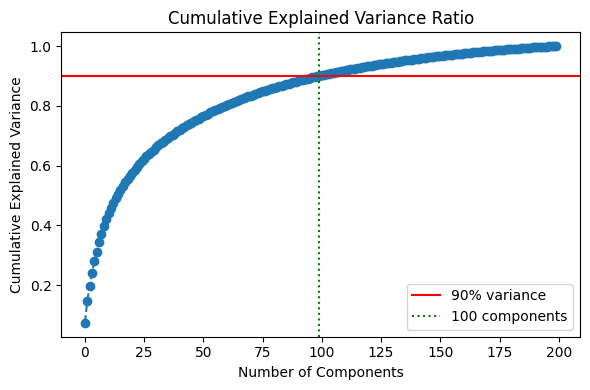

✅ 100 components are needed to explain 90% of the variance.


In [30]:
# 1️⃣ Applique la PCA
pca = PCA()
pca.fit(vel_grids_tab)

# 2️⃣ Calcule la variance expliquée cumulée
cum_var = np.cumsum(pca.explained_variance_ratio_)

# 3️⃣ Trouve le nombre minimal de composantes expliquant 90% de la variance
n_components_90 = np.argmax(cum_var >= 0.9) + 1

# 4️⃣ Trace le graphe
plt.figure(figsize=(6, 4))
plt.plot(cum_var, marker='o', linestyle='--')
plt.axhline(y=0.9, color='r', linestyle='-', label='90% variance')
plt.axvline(x=n_components_90 - 1, color='g', linestyle=':', label=f'{n_components_90} components')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.tight_layout()
plt.show()

print(f"✅ {n_components_90} components are needed to explain 90% of the variance.")

**2.d)** Reconstruct the first timestep from the first 10 PCA compoents. Visualize the result, and compare to the original time step. *Hint:* Don't forget to add the mean vector back.

How well does the reconstruction represent the airflow?

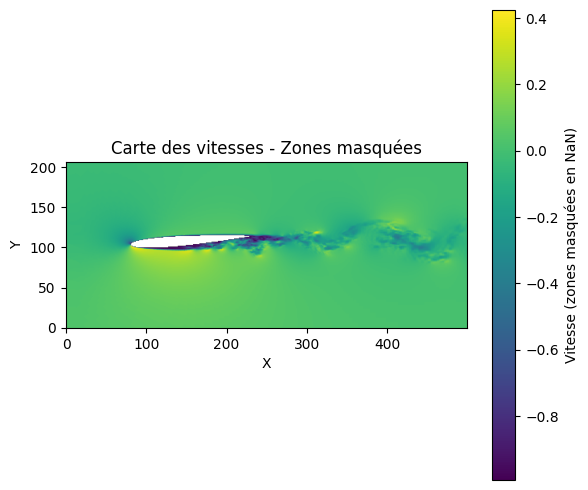

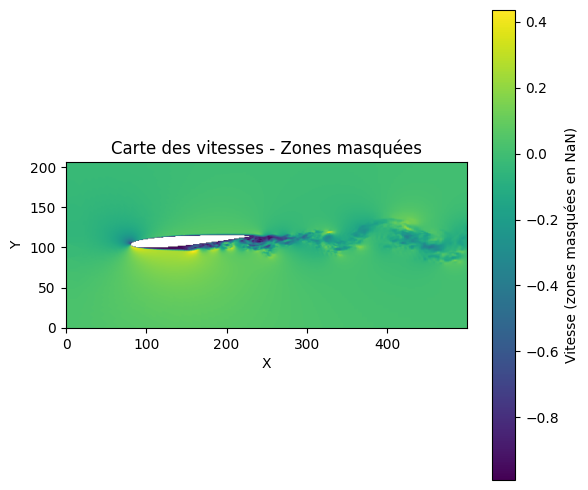

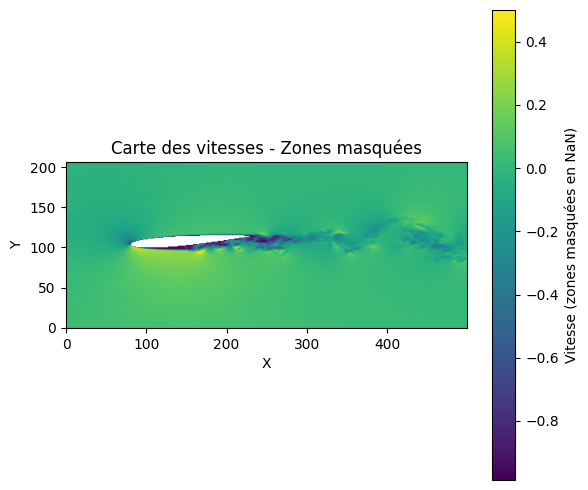

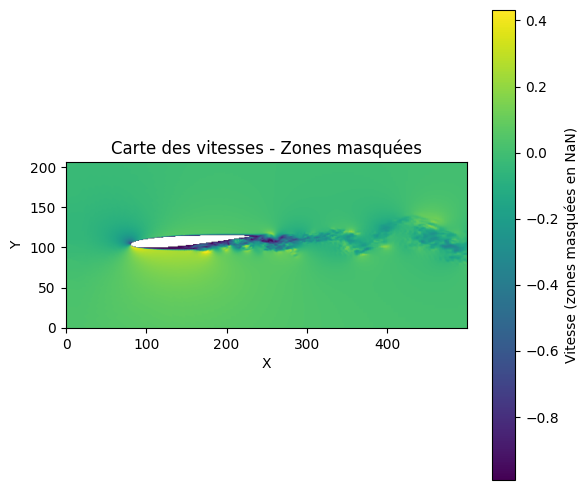

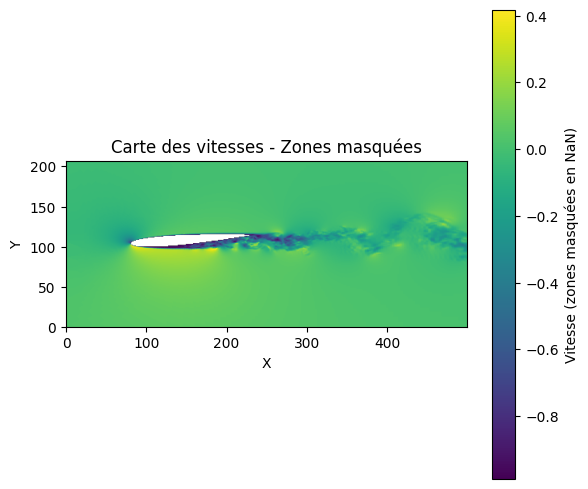

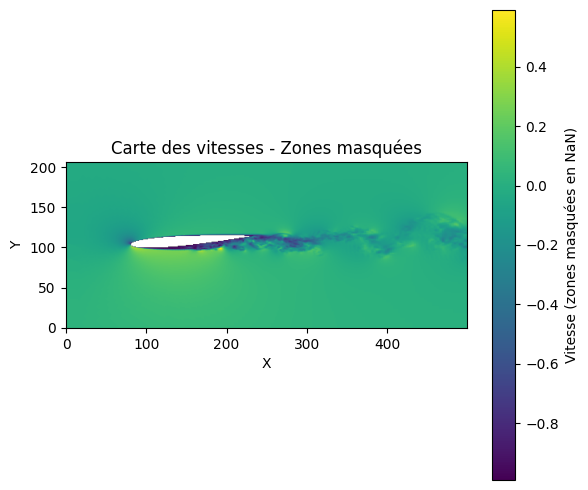

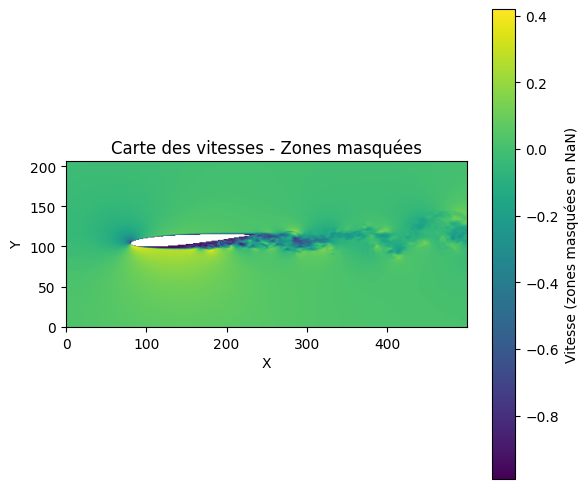

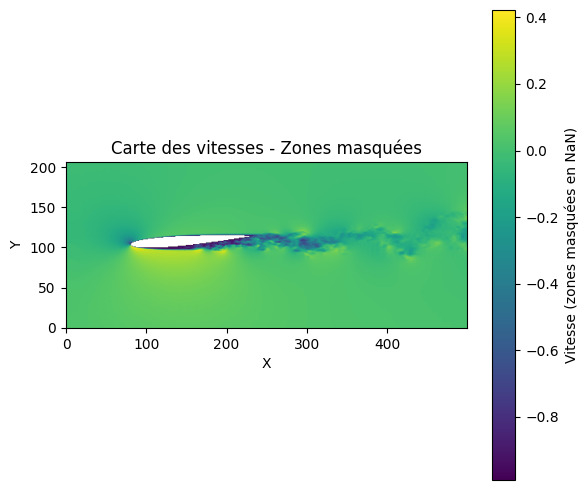

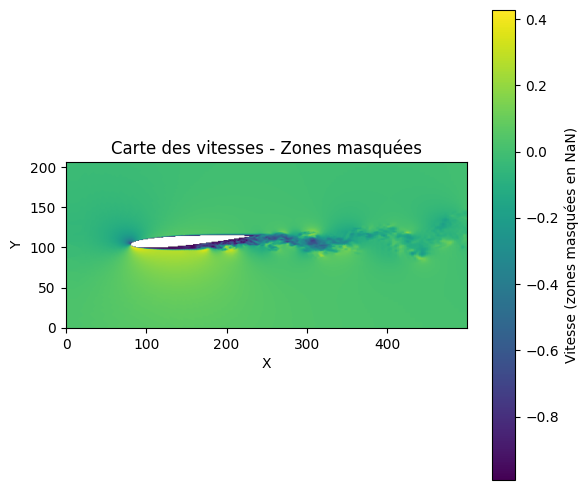

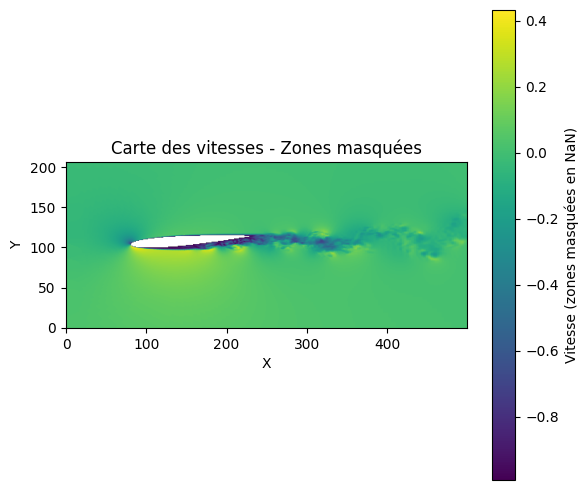

In [36]:
# Transformation PCA
vel_grids_trans = pca.transform(vel_grids_tab)

# Reconstruction du premier timestep avec 10 composantes principales
n_components = 10
vel_recon_first = np.dot(
    vel_grids_trans[0, :n_components],
    pca.components_[:n_components, :]
) + pca.mean_

for i in range(n_components):
    plt.figure(figsize=(6, 5))
    plt.imshow(visualize_2d(vel_grids_tab[i]), origin='lower', cmap='viridis')
    plt.colorbar(label="Vitesse (zones masquées en NaN)")
    plt.title("Carte des vitesses - Zones masquées")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    plt.show()

**2.e)** Visualize for three random timesteps the reconstructions for 10, 50 and (your answer from 2.c) principal components. Which reconstruction is visually convincing?

Random timesteps: [95 15 30]


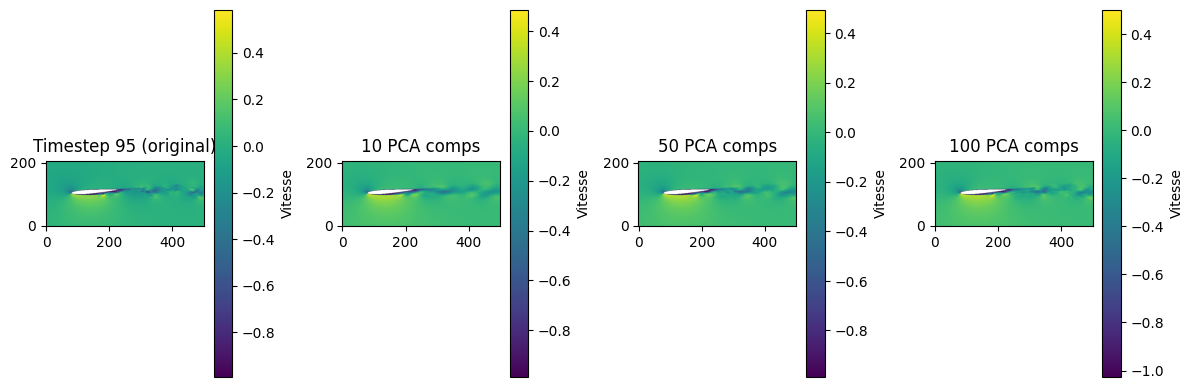

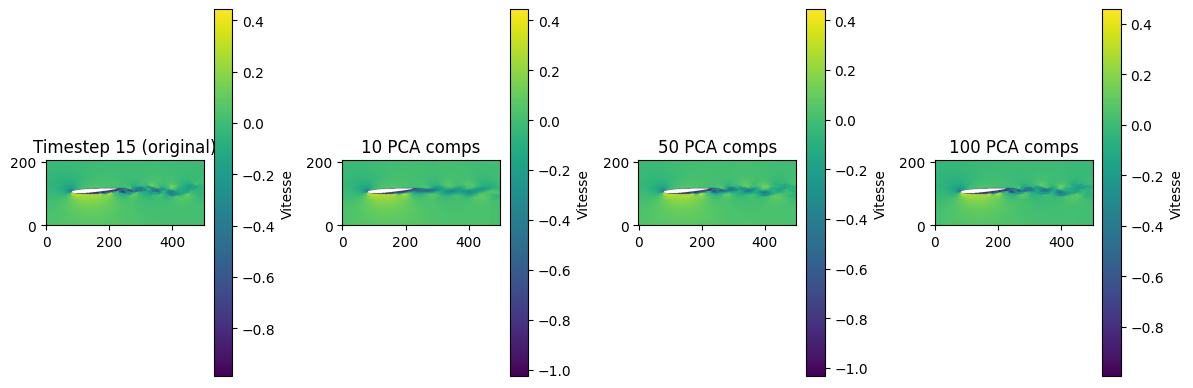

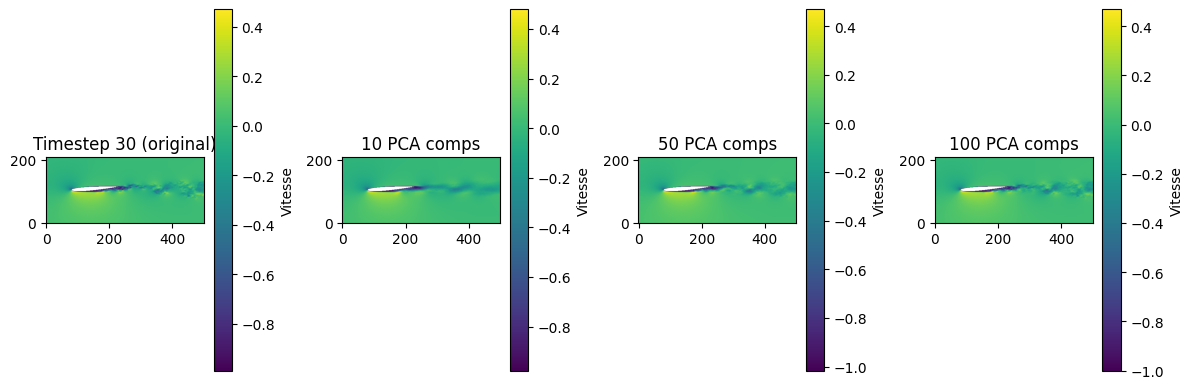

In [37]:
# Sélection de 3 pas de temps aléatoires
np.random.seed(42)
random_indices = np.random.choice(len(vel_grids_tab), 3, replace=False)
print("Random timesteps:", random_indices)

# Nombres de composantes à tester
components_list = [10, 50, n_components_90]

# Boucle sur les trois pas de temps choisis
for idx in random_indices:
    plt.figure(figsize=(12, 4))

    # Donnée originale
    original = vel_grids_tab[idx]
    plt.subplot(1, 4, 1)
    plt.imshow(visualize_2d(original), origin='lower', cmap='viridis')
    plt.title(f"Timestep {idx} (original)")
    plt.colorbar(label="Vitesse")

    # Reconstructions avec différents nombres de composantes
    for j, n_comp in enumerate(components_list, start=2):
        recon = np.dot(
            pca.transform(vel_grids_tab)[idx, :n_comp],
            pca.components_[:n_comp, :]
        ) + pca.mean_

        plt.subplot(1, 4, j)
        plt.imshow(visualize_2d(recon), origin='lower', cmap='viridis')
        plt.title(f"{n_comp} PCA comps")
        plt.colorbar(label="Vitesse")

    plt.tight_layout()
    plt.show()

**2.f)** Plot the time evolution of the first principal components coefficient. Do you think the system is regular enough to predict future dynamics by fitting this time evolution with a non-linear function, and extrapolating into future times?

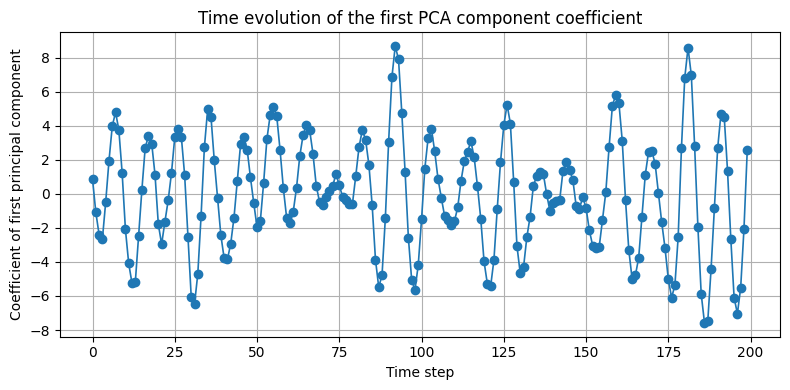

In [38]:
# Projette les données sur les composantes principales
vel_grids_trans = pca.transform(vel_grids_tab)

# Extrais le premier coefficient PCA pour chaque pas de temps
first_component = vel_grids_trans[:, 0]

# Axe temporel (si tu as un vrai temps, remplace par ton vecteur de temps)
time = np.arange(len(first_component))

# Trace l’évolution temporelle
plt.figure(figsize=(8, 4))
plt.plot(time, first_component, marker='o', linestyle='-', linewidth=1.2)
plt.title("Time evolution of the first PCA component coefficient")
plt.xlabel("Time step")
plt.ylabel("Coefficient of first principal component")
plt.grid(True)
plt.tight_layout()
plt.show()

# Bibliography

- [1] Towne, A., Yeh, C., Patel, H., Taira, K. (2022). Turbulent airfoil wake large eddy simulation [Data set], University of Michigan - Deep Blue Data. https://doi.org/10.7302/0e3g-6j84
- [2] Taira, K., Brunton, S. L., Dawson, S. T. M., Rowley, C. W., Colonius, T., McKeon, B. J., Schmidt, O. T., Gordeyev, S., Theofilis, V., & Ukeiley, L. S. (2017). Modal Analysis of Fluid Flows: An Overview [Preprint]. arXiv. https://doi.org/10.48550/arXiv.1702.01453